# configuration

In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import gc
import itertools
import pickle
import re
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Data Downloading

In [ ]:
# PLEASE REPLACE THE FILEPATH INTO
power_consumption_prediction = pd.read_csv('/content/itu_ml5g_ps_001/power_consumption_prediction.csv')
Energy_consumption_data = pd.read_csv('/content/itu_ml5g_ps_001/Energy_consumption_data.csv')
Cell_level_data = pd.read_csv('/content/itu_ml5g_ps_001/Cell_level_data.csv')
Base_Station_basic_information = pd.read_csv('/content/itu_ml5g_ps_001/Base_Station_basic_information.csv')

# Data Pre-Processing

In [ ]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [ ]:
power_consumption_prediction = rename_columns(power_consumption_prediction)
Energy_consumption_data = rename_columns(Energy_consumption_data)
Cell_level_data = rename_columns(Cell_level_data)
Base_Station_basic_information = rename_columns(Base_Station_basic_information)

In [ ]:

# This what we want to predict
print("================power_consumption_prediction==============")
print(power_consumption_prediction.info())
print(power_consumption_prediction.head())
print("================Energy_consumption_data==============")
print(Energy_consumption_data.info())
print(Energy_consumption_data.head())
print("================Cell_level_data==============")
print(Cell_level_data.info())
print(Cell_level_data.head())
print("================Cell_level_data==============")
print(Base_Station_basic_information.info())
print(Base_Station_basic_information.head())

================power_consumption_prediction==============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26139 entries, 0 to 26138
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    26139 non-null  object 
 1   bs      26139 non-null  object 
 2   energy  0 non-null      float64
 3   w       26139 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 817.0+ KB
None
                  time   bs  energy  w
0  2023-01-01 06:00:00  B_0     NaN  1
1  2023-01-01 11:00:00  B_0     NaN  1
2  2023-01-01 12:00:00  B_0     NaN  1
3  2023-01-01 13:00:00  B_0     NaN  1
4  2023-01-01 23:00:00  B_0     NaN  1
================Energy_consumption_data==============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    92629 non-null  object 
 1   bs      92629 non-null  object

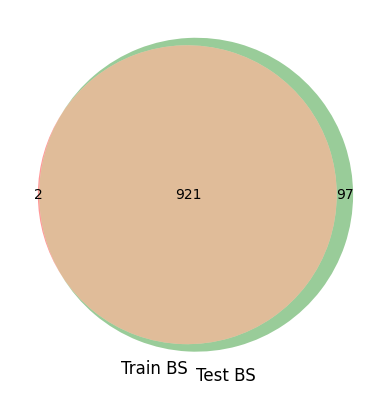

In [ ]:
train_bs_set = set(Energy_consumption_data['bs'].values.tolist())
test_bs_set = set(power_consumption_prediction['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [ ]:
Cell_level_data['time'] = pd.to_datetime(Cell_level_data['time'])
Energy_consumption_data['time'] = pd.to_datetime(Energy_consumption_data['time'])
power_consumption_prediction['time'] = pd.to_datetime(power_consumption_prediction['time'])

In [ ]:
cl_bs_df = Cell_level_data.merge(Base_Station_basic_information, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [ ]:
product_features = ['load',  'frequency', 'bandwidth','antennas', 'txpower']

product_feature_pairs =  list(itertools.combinations(product_features, 2))
# print(len(product_feature_pairs))

for pair in product_feature_pairs:
    cl_bs_df[pair[0] + '_product_' + pair[1]] = cl_bs_df[pair[0]] * cl_bs_df[pair[1]]
    cl_bs_df[pair[0] + '_minus_' + pair[1]] = cl_bs_df[pair[0]] - cl_bs_df[pair[1]]

# cl_bs_df.info()


In [ ]:
cl_bs_df = cl_bs_df.replace({'rutype':{'Type1': 1, 'Type2': 2, 'Type3': 3, 'Type4': 4, 'Type5': 5, 'Type6': 6, 'Type7': 7, 'Type8': 8, 'Type9': 9, 'Type10': 10, 'Type8Type8': 8, 'Type11': 11,  'Type12': 12}})
cl_bs_df = cl_bs_df.replace({'mode': {'Mode1': 1, 'Mode2': 2}})

In [ ]:
cl_bs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125575 entries, 0 to 125574
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   time                         125575 non-null  datetime64[ns]
 1   bs                           125575 non-null  object        
 2   cellname                     125575 non-null  object        
 3   load                         125575 non-null  float64       
 4   esmode1                      125575 non-null  float64       
 5   esmode2                      125575 non-null  float64       
 6   esmode3                      125575 non-null  float64       
 7   esmode4                      125575 non-null  int64         
 8   esmode5                      125575 non-null  float64       
 9   esmode6                      125575 non-null  float64       
 10  rutype                       125575 non-null  int64         
 11  mode                      

In [ ]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,...,frequency_product_antennas,frequency_minus_antennas,frequency_product_txpower,frequency_minus_txpower,bandwidth_product_antennas,bandwidth_minus_antennas,bandwidth_product_txpower,bandwidth_minus_txpower,antennas_product_txpower,antennas_minus_txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,...,1460.00,361.00,2509.715994,358.124066,80,16,137.518685,13.124066,27.503737,-2.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,...,1460.00,361.00,2509.715994,358.124066,80,16,137.518685,13.124066,27.503737,-2.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,...,1460.00,361.00,2509.715994,358.124066,80,16,137.518685,13.124066,27.503737,-2.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,...,1460.00,361.00,2509.715994,358.124066,80,16,137.518685,13.124066,27.503737,-2.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,...,1460.00,361.00,2509.715994,358.124066,80,16,137.518685,13.124066,27.503737,-2.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,...,1707.92,422.98,3128.697546,419.652496,8,-2,14.655007,-5.327504,29.310015,-3.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,...,1707.92,422.98,3128.697546,419.652496,8,-2,14.655007,-5.327504,29.310015,-3.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,...,1707.92,422.98,3128.697546,419.652496,8,-2,14.655007,-5.327504,29.310015,-3.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,...,1707.92,422.98,3128.697546,419.652496,8,-2,14.655007,-5.327504,29.310015,-3.327504


In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique()

bs
B_0       2
B_1       1
B_10      2
B_100     1
B_1000    1
         ..
B_995     1
B_996     1
B_997     1
B_998     1
B_999     1
Name: cellname, Length: 1020, dtype: int64

In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

1    827
2    191
4      2
Name: cellname, dtype: int64

In [ ]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower', 'rutype', 'mode',
        'load_product_frequency',
        'load_minus_frequency',
        'load_product_bandwidth',
        'load_minus_bandwidth',
        'load_product_antennas',
        'load_minus_antennas',
        'load_product_txpower',
        'load_minus_txpower',
        'frequency_product_bandwidth',
        'frequency_minus_bandwidth',
        'frequency_product_antennas',
        'frequency_minus_antennas',
        'frequency_product_txpower',
        'frequency_minus_txpower',
        'bandwidth_product_antennas',
        'bandwidth_minus_antennas',
        'bandwidth_product_txpower',
        'bandwidth_minus_txpower',
        'antennas_product_txpower',
        'antennas_minus_txpower',], #'year', 'month', 'day', 'hour'],
                ).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)

# cl_bs_df = cl_bs_df.merge(Base_Station_basic_information.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [ ]:
cl_bs_df['year'] = pd.to_datetime(cl_bs_df['time'],format='%Y-%m-%d %H:%M:%S').dt.year
cl_bs_df['month'] = pd.to_datetime(cl_bs_df['time'],format='%Y-%m-%d %H:%M:%S').dt.month
cl_bs_df['day'] = pd.to_datetime(cl_bs_df['time'],format='%%Y-%m-%d %H:%M:%S').dt.day
cl_bs_df['hour'] = pd.to_datetime(cl_bs_df['time'],format='%%Y-%m-%d %H:%M:%S').dt.hour

In [ ]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,...,antennas_product_txpower_cell2,antennas_product_txpower_cell3,antennas_minus_txpower_cell0,antennas_minus_txpower_cell1,antennas_minus_txpower_cell2,antennas_minus_txpower_cell3,year,month,day,hour
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,-2.875934,NaN,NaN,NaN,2023,1,1,1
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,-2.875934,NaN,NaN,NaN,2023,1,1,1
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,-4.875934,NaN,NaN,NaN,2023,1,1,1
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,-4.875934,NaN,NaN,NaN,2023,1,1,1
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,-4.875934,NaN,NaN,NaN,2023,1,1,1


In [ ]:
cl_bs_df.describe()

,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,...,antennas_product_txpower_cell2,antennas_product_txpower_cell3,antennas_minus_txpower_cell0,antennas_minus_txpower_cell1,antennas_minus_txpower_cell2,antennas_minus_txpower_cell3,year,month,day,hour
count,118768.000000,6711.000000,48.000000,48.000000,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,...,48.000000,48.000000,118768.000000,6711.000000,48.000000,48.000000,118768.0,118768.0,118768.000000,118768.000000
mean,0.246362,0.111214,0.070212,0.081115,0.042145,0.004985,0.0,0.0,0.038640,0.003311,...,13.754858,13.754858,-4.235707,-4.810803,-4.877429,-4.877429,2023.0,1.0,3.514330,11.571147
std,0.239354,0.091569,0.023807,0.038373,0.194184,0.064911,0.0,0.0,0.186785,0.052831,...,0.000000,0.000000,4.497427,0.746761,0.000000,0.000000,0.0,0.0,1.827032,6.890629
min,0.000000,0.008190,0.045942,0.045904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,13.754858,13.754858,-5.875934,-5.875934,-4.877429,-4.877429,2023.0,1.0,1.000000,0.000000
25%,0.055714,0.051894,0.054442,0.051822,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,13.754858,13.754858,-4.875934,-5.325859,-4.877429,-4.877429,2023.0,1.0,2.000000,6.000000
50%,0.162470,0.079423,0.066760,0.067856,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,13.754858,13.754858,-4.875934,-4.877429,-4.877429,-4.877429,2023.0,1.0,3.000000,12.000000
75%,0.367142,0.138202,0.079385,0.095495,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,13.754858,13.754858,-4.427504,-4.427504,-4.877429,-4.877429,2023.0,1.0,5.000000,18.000000
max,0.993957,0.891770,0.174846,0.196519,1.000000,1.000000,0.0,0.0,1.000000,1.000000,...,13.754858,13.754858,56.112556,0.449925,-4.877429,-4.877429,2023.0,1.0,8.000000,23.000000


In [ ]:
df = cl_bs_df.merge(Energy_consumption_data, on=['time', 'bs'], how='left')

In [ ]:
df['energy'].isna().value_counts()

False    92629
True     26139
Name: energy, dtype: int64

In [ ]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

# EDA(Exploratory Data Analysis)

In [ ]:
df['energy'].describe()

count    92629.000000
mean        28.138997
std         13.934645
min          0.747384
25%         18.236173
50%         24.065770
75%         35.724963
max        100.000000
Name: energy, dtype: float64

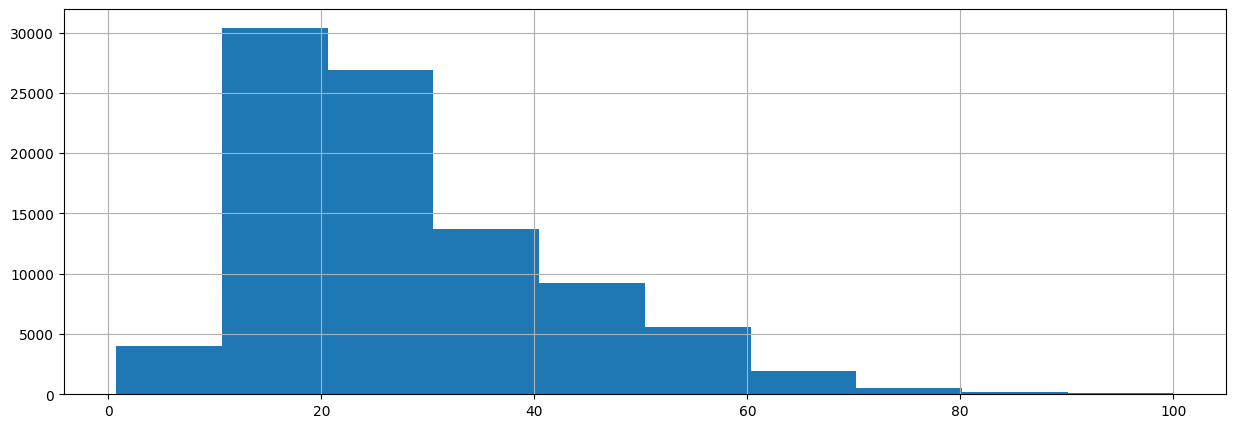

In [ ]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

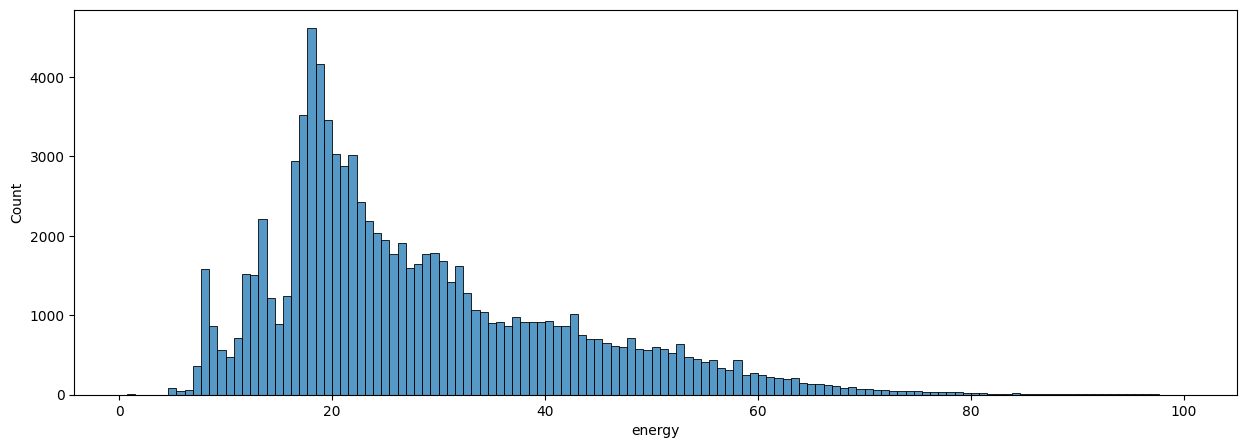

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

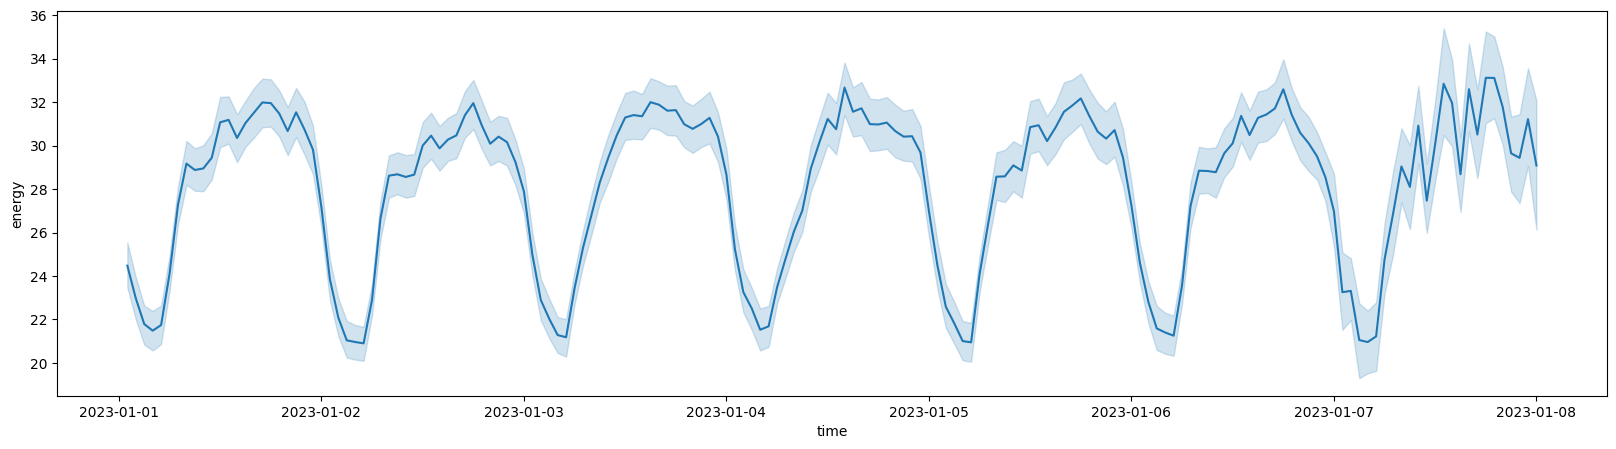

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

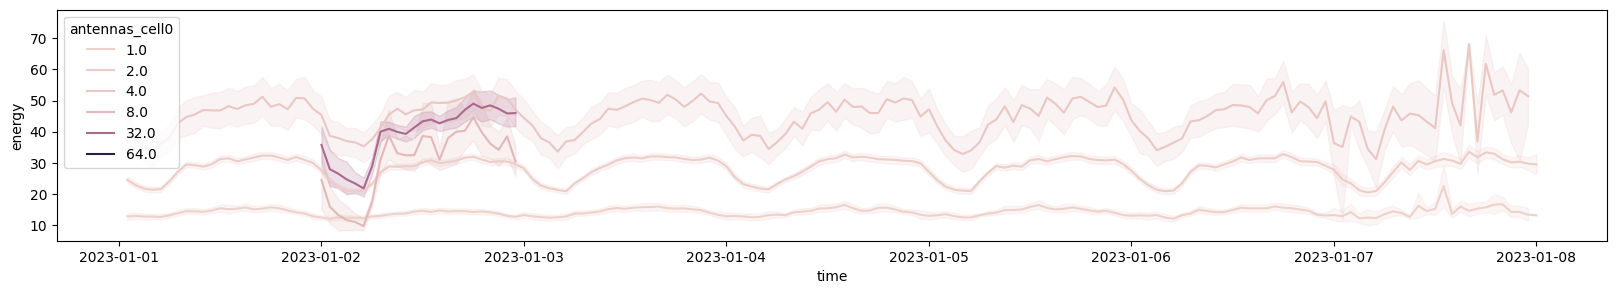

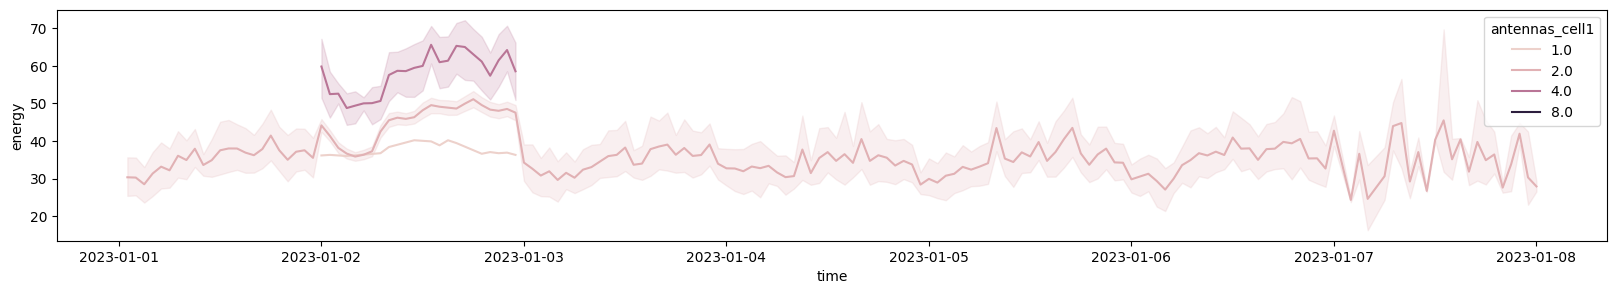

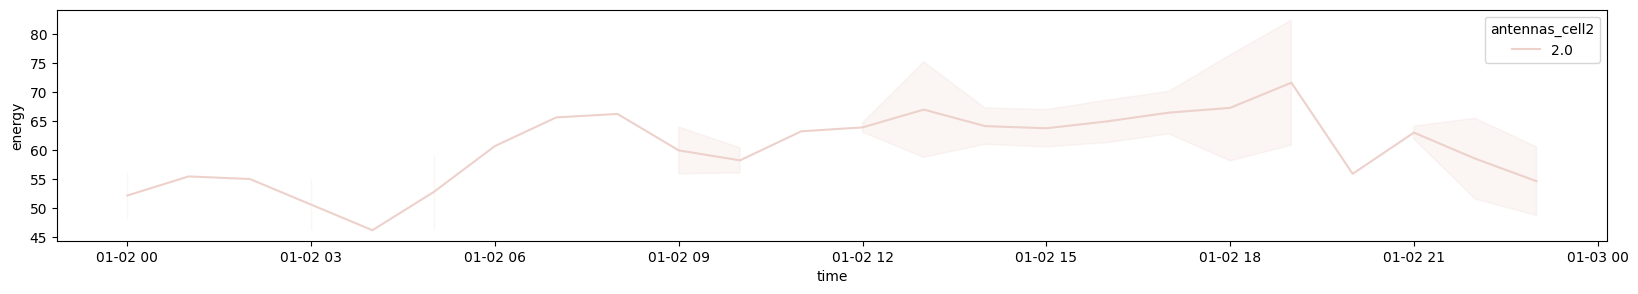

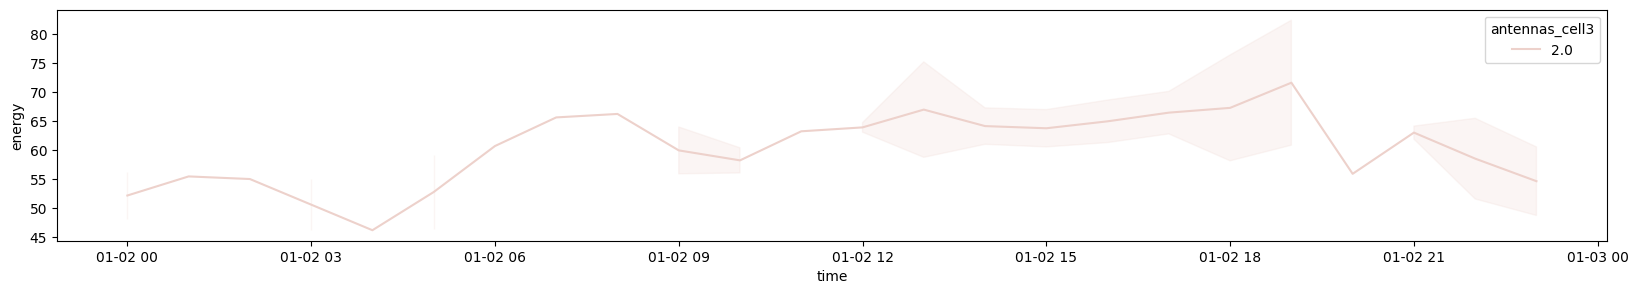

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

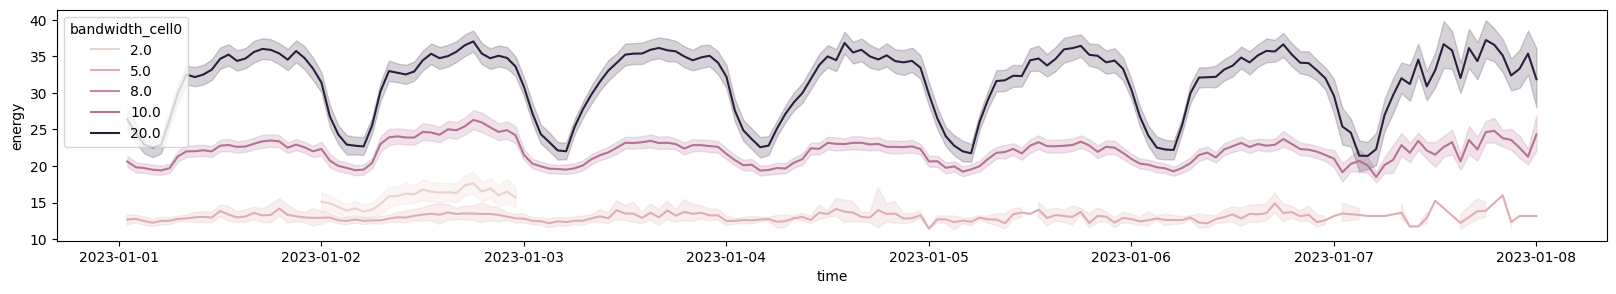

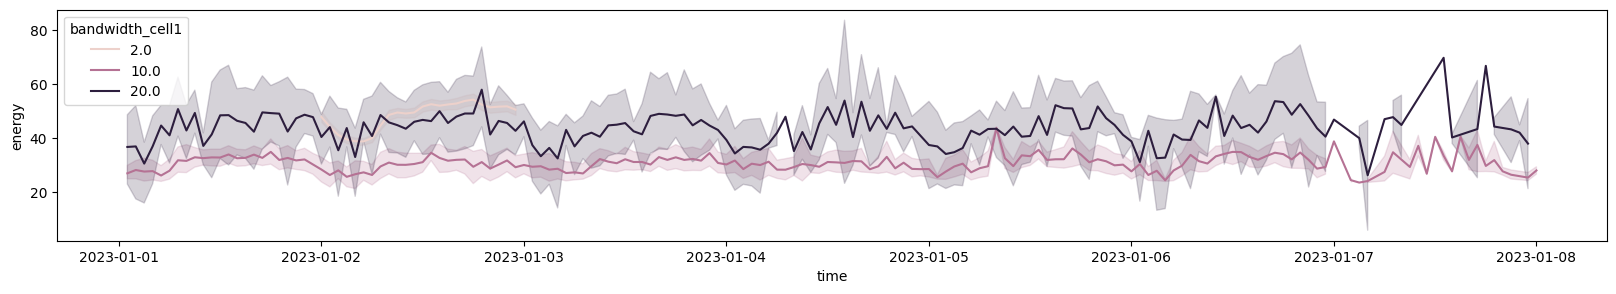

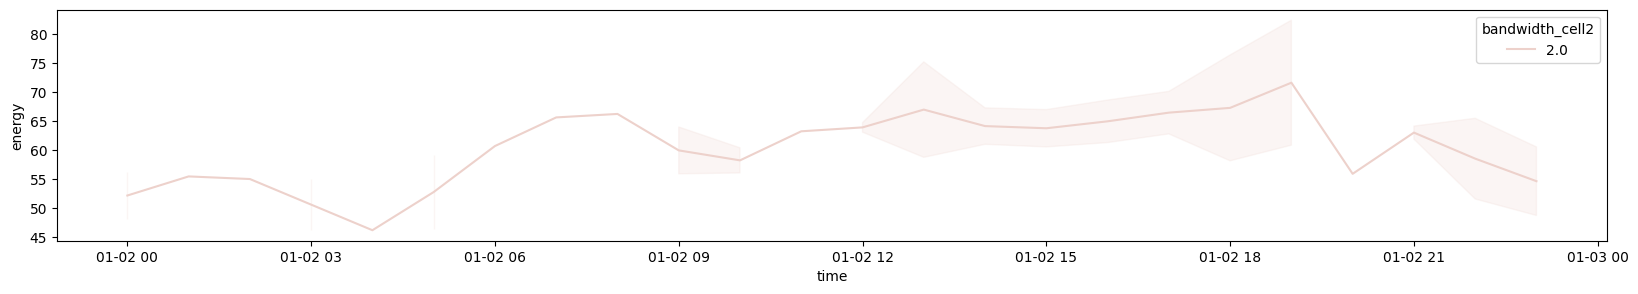

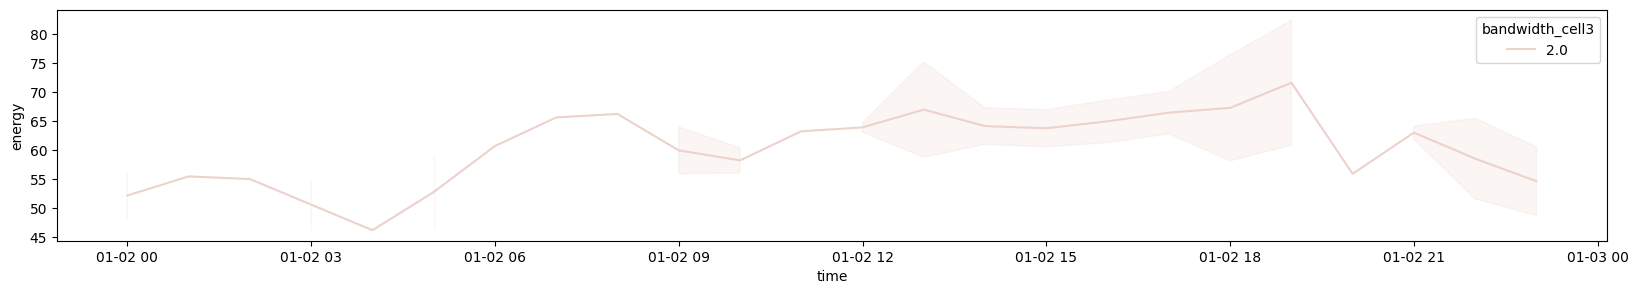

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

In [ ]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

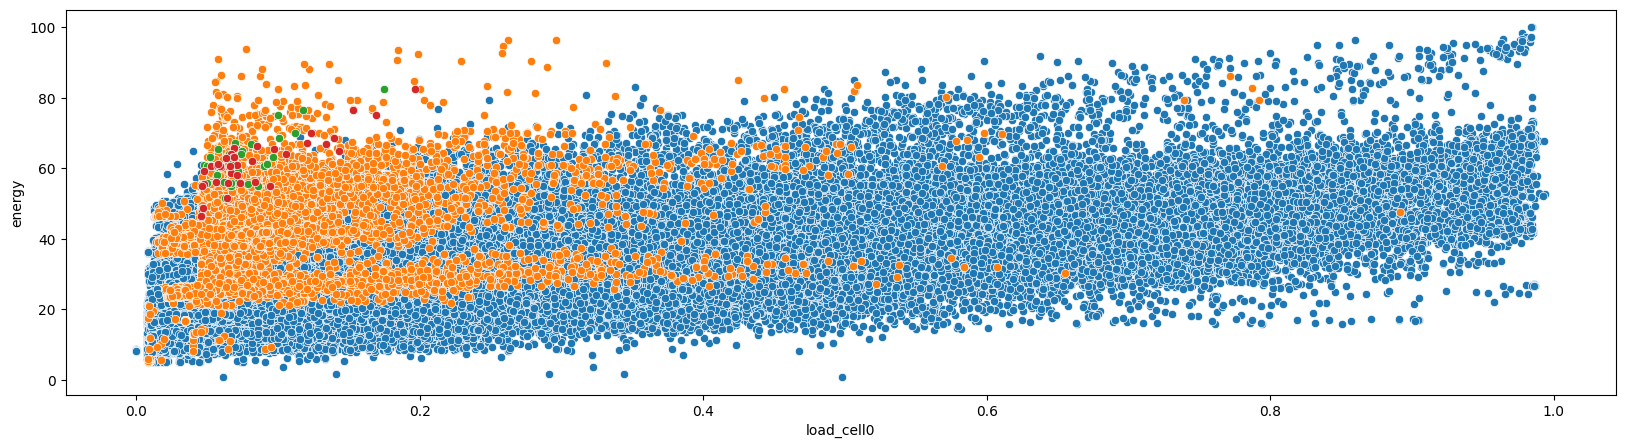

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell3', y='energy')
plt.show()

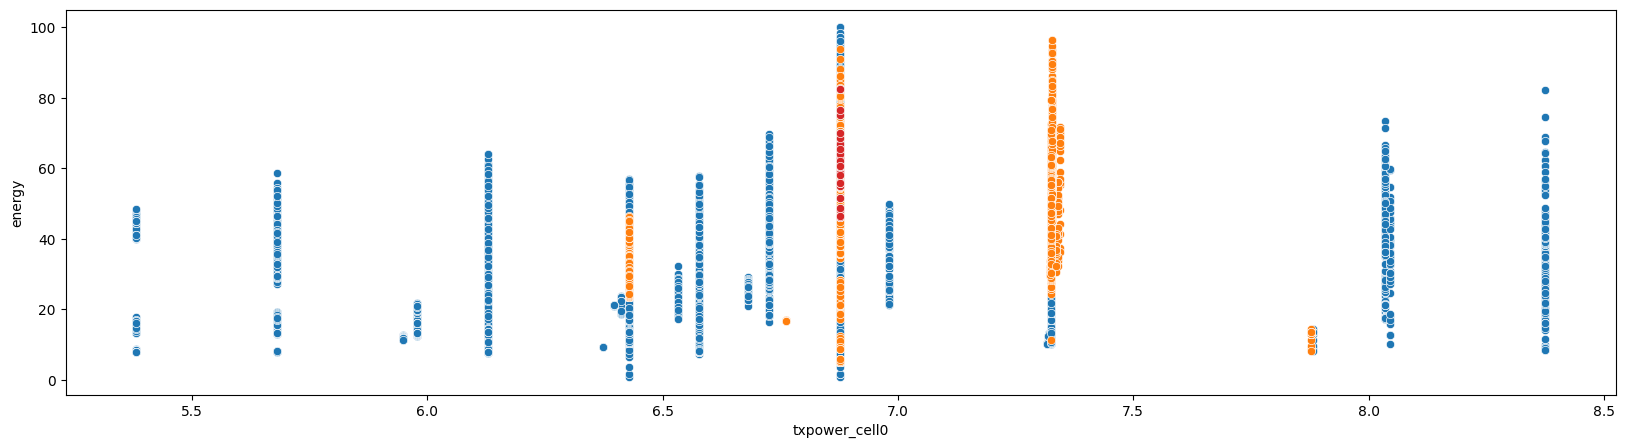

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell3', y='energy')
plt.show()

In [ ]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 140), (26139, 140))

In [ ]:
train_data.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,...,antennas_minus_txpower_cell0,antennas_minus_txpower_cell1,antennas_minus_txpower_cell2,antennas_minus_txpower_cell3,year,month,day,hour,energy,split
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-2.875934,NaN,NaN,NaN,2023,1,1,1,64.275037,train
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-2.875934,NaN,NaN,NaN,2023,1,1,1,18.086697,train
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.875934,NaN,NaN,NaN,2023,1,1,1,30.343797,train
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.875934,NaN,NaN,NaN,2023,1,1,1,15.545590,train
5,2023-01-01 01:00:00,B_102,0.025720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.427504,NaN,NaN,NaN,2023,1,1,1,17.488789,train


In [ ]:
print("==================training data=====================")
# train_data = train_data.drop(columns = ['split'])
train_data.info()
train_data.head()

print("==================test data=====================")
# test_data = test_data.drop(columns = ['split'])
test_data.info()
test_data.head()

==================training data=====================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92629 entries, 0 to 118767
Columns: 140 entries, time to split
dtypes: datetime64[ns](1), float64(133), int64(4), object(2)
memory usage: 99.6+ MB
==================test data=====================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26139 entries, 3 to 118765
Columns: 140 entries, time to split
dtypes: datetime64[ns](1), float64(133), int64(4), object(2)
memory usage: 28.1+ MB


,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,...,antennas_minus_txpower_cell0,antennas_minus_txpower_cell1,antennas_minus_txpower_cell2,antennas_minus_txpower_cell3,year,month,day,hour,energy,split
3,2023-01-01 01:00:00,B_100,0.01122,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.875934,NaN,NaN,NaN,2023,1,1,1,NaN,test
8,2023-01-01 01:00:00,B_105,0.05030,0.01674,NaN,NaN,0.0,0.0,NaN,NaN,...,-4.875934,-4.875934,NaN,NaN,2023,1,1,1,NaN,test
10,2023-01-01 01:00:00,B_107,0.49716,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.128550,NaN,NaN,NaN,2023,1,1,1,NaN,test
15,2023-01-01 01:00:00,B_111,0.37218,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.128550,NaN,NaN,NaN,2023,1,1,1,NaN,test
18,2023-01-01 01:00:00,B_114,0.46663,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,-4.875934,NaN,NaN,NaN,2023,1,1,1,NaN,test


In [ ]:
train_data.to_csv('train_minus_product.csv')
test_data.to_csv('test_minus_product.csv')
df.to_csv('merge_minus_product.csv')